# Quickstart Example with Synthetic RTB Simulation and Dataset (Continuous)
This notebook provides an example of conducting **Off-policy Evaluation (OPE) and Offline Reinforcement Learning (Offline RL) on a synthetic Real-Time Bidding (RTB) dataset**.

Our example with Synthetic RTB Simulation and Dataset consists of the following 5 steps:
0. (Setup Synthetic RTB Simulation Environment and Online RL)
1. Synthetic Data Generation
2. Offline Reinforcement Learning
3. Off-Policy Evaluation and Evaluation of Offline RL methods
4. Evaluation of OPE methods

We also show how to visualize the results in the Appendix.

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of online/offline rl policies and model-based evaluation.  
\* Also, our OPE implementations are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# import SCOPE-RL modules
import scope_rl
from rtbgym import RTBEnv, CustomizedRTBEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead, ContinuousTruncatedGaussianHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from scope_rl.utils import MinMaxScaler, MinMaxActionScaler


# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [4]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# version
print(scope_rl.__version__)

0.0.0


In [6]:
# set random state
random_state = 12345

In [7]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 0. (Setup Synthetic RTB Simulation Environment and Online RL)
To begin with, we briefly describe how the RTB environment works.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as number of clicks or conversions) within an episode under given budget constraints. We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the followings.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

For more about the environmental configurations, please refer to [examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb).

Then, Let's see how it works!

In [8]:
# setup environment
env = RTBEnv(random_state=random_state)

In [9]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    ),
    name="random",
)

In [10]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [11]:
# state consists of the following feedback from the environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


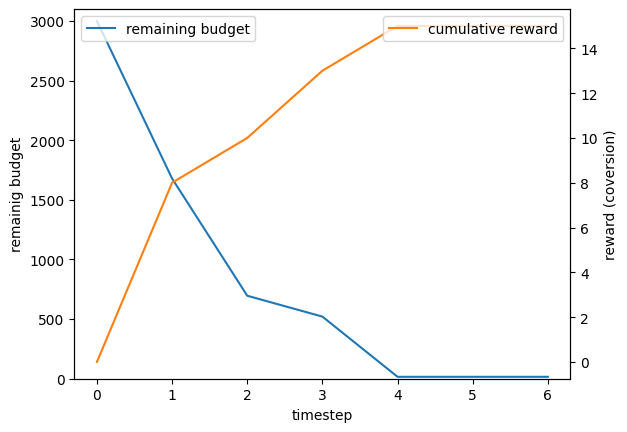

In [12]:
# let's visualize the transition of remaining budget and the cumulative reward
# our goal is to obtain a policy (i.e., agent) that maximizes the cumulative reward under budget constraints using RL.  
# for more visualization, please see the appendix.
obs, info = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

We see that the random policy run out the budget quickly.  
Our goal is to derive a policy that controls the adjust rate (i.e., action) to maximize the reward while meeting the given budget constraints.

For more about the environmental configurations and customization, please refer to [examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb).

#### Online RL and comparison of the policies
We now learn an online RL policy and compare it to the random policy, based on their on-policy policy value estimation.

In [13]:
# standardized environment for continuous actions
env = gym.make("RTBEnv-continuous-v0")
print(env.action_space)

Box(0.1, 10.0, (1,), float64)


In [14]:
# for api compatibility to d3rlpy
from scope_rl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

In [15]:
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [ ]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [18]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [16]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

Text(0, 0.5, 'episode reward')

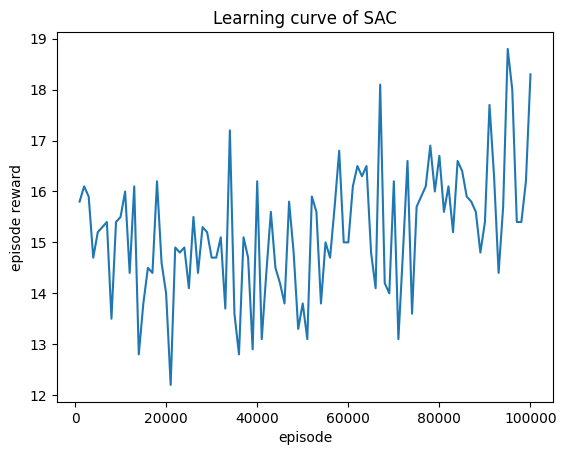

In [17]:
# may need more interactions to converge
log_path = sorted(glob("d3rlpy_logs/SAC_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of SAC")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [18]:
random = ContinuousRandomPolicy(
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

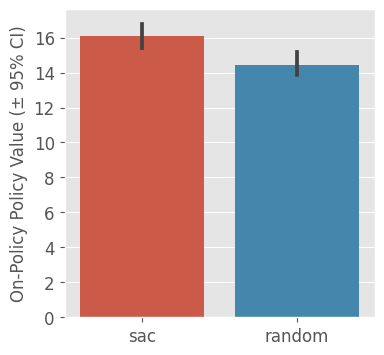

In [19]:
# compare the performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, random],
    policy_names=["sac", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [20]:
# on-policy policy value of the sac policy
# slightly improves that of the random policy
sac_performance = calc_on_policy_policy_value(env, sac, n_trajectories=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_trajectories=100, random_state=random_state)
print("relative improvement:", (sac_performance - random_performance) / random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

relative improvement: 0.11141868512110724


Note that, we provide the following functions for online evaluation of the policy performance under `scope_rl.ope.online`.

(Statistics)

* `calc_on_policy_policy_value`
* `calc_on_policy_policy_value_interval`
* `calc_on_policy_variance`
* `calc_on_policy_conditional_value_at_risk`
* `calc_on_policy_policy_interquartile_range`
* `calc_on_policy_cumulative_distribution_function`

(Visualization)
* `visualize_on_policy_policy_value`
* `visualize_on_policy_policy_value_with_variance`
* `visualize_on_policy_cumulative_distribution_function`
* `visualize_on_policy_conditional_value_at_risk`
* `visualize_on_policy_interquartile_range`

## 1. Synthetic Dataset Generation
In the previous section, we see how we can interact with the environment *online* using synthetic simulator.  
Though simulation is a good starting point for training an agent, eventually we want to deploy our agent (or policy) in the real world environment.  
However, online interaction may have potential risk of failure in the real-world.
Therefore, we introduce an alternative learning protocol, Offline RL, which aims at training a new policy using only offline logged dataset collected by a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

We prepare an easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding simulation environment as a hypothetical real-environment, we show how to conduct Offline RL leveraging logged data.  
For detailed description of how to use real-world dataset, please see #TODO (will be implemented).

`SyntheticDataset` has the following arguments:
- `env`: RTB environment for RL defined in the previous section.
- `state_keys`: Name of the state variable at each dimension.
- `max_episode_steps`: Maximum number of timesteps in an episode.
- `info_keys`: Dictionary containing of key and the type of info components.

In [21]:
behavior_policy = ContinuousTruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [22]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [26]:
# collect logged data by the behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state + 1,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [25]:
train_logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 1,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 4.30367299e-01],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 7.99228658e+00],
        [2.00000000e+00, 1.78300000e+03, 6.64921466e-02, ...,
         1.80487805e-01, 1.00000000e+00, 6.70770613e-01],
        ...,
        [4.00000000e+00, 4.37000000e+02, 7.14751958e-01, ...,
         1.00000000e+00, 4.00000000e+00, 8.70305160e+00],
        [5.00000000e+00, 2.70000000e+01, 9.38215103e-01, ...,
         2.31527094e-01, 3.00000000e+00, 5.64240654e+00],
        [6.00000

In [28]:
with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [24]:
with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

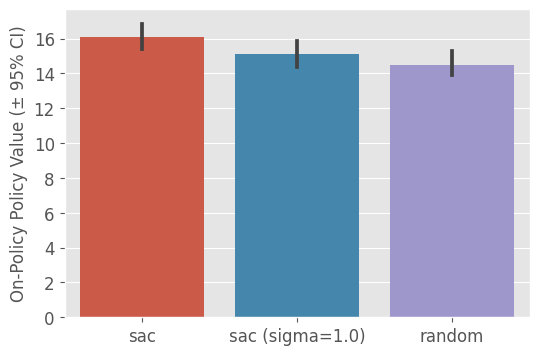

In [26]:
# compare the policy performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, behavior_policy, random],
    policy_names=["sac", "sac (sigma=1.0)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [27]:
# let's see some statistics of the logged dataset
df = pd.DataFrame()
df['adjust rate'] = train_logged_dataset['state'][:, 6]
df['average bid price'] = train_logged_dataset['info']['average_bid_price']
df['impression'] = train_logged_dataset['info']['impression']
df['click'] = train_logged_dataset['info']['click']
df['conversion'] = train_logged_dataset['info']['conversion']
df['winning rate'] = train_logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,4.431999,251.007174,91.023086,8.780043,2.168271,0.520184,0.064258,0.138964
std,3.365812,160.958569,86.723720,9.285247,3.051211,0.412629,0.068473,0.183659
min,0.000033,4.345455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.217826,103.712668,6.000000,0.000000,0.000000,0.061092,0.000000,0.000000
50%,3.756188,232.451849,56.000000,5.000000,1.000000,0.537073,0.074380,0.052632
75%,7.934745,403.492028,184.000000,17.000000,3.000000,1.000000,0.105263,0.249999
max,9.999895,549.198020,290.000000,41.000000,20.000000,1.000000,0.999997,0.999998


For more about the data collection and visualization, please refer to [examples/quickstart/rtb/rtb_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_data_collection.ipynb).

## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting with the environment.
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of offline RL algorithms.

In [28]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL as ContinuousCQL
from d3rlpy.ope import FQE as ContinuousFQE
from d3rlpy.metrics.scorer import evaluate_on_environment

In [29]:
offlinerl_dataset = MDPDataset(
    observations=test_logged_dataset["state"],
    actions=test_logged_dataset["action"],
    rewards=test_logged_dataset["reward"],
    terminals=test_logged_dataset["done"],
    episode_terminals=test_logged_dataset["done"],
    discrete_action=False,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [30]:
# Use Conservative Q-Learning policy
cql = ContinuousCQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={
        'environment': evaluate_on_environment(env_),
        # to record training process w/ ground truth policy value, which is unseen to the agent
    },
)

In [32]:
# save model
cql.save_model("d3rlpy_logs/cql_continuous.pt")

In [33]:
# reload model
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_continuous.pt")

2023-06-01 17:59:10 [warning  ] Parameters will be reinitialized.


[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

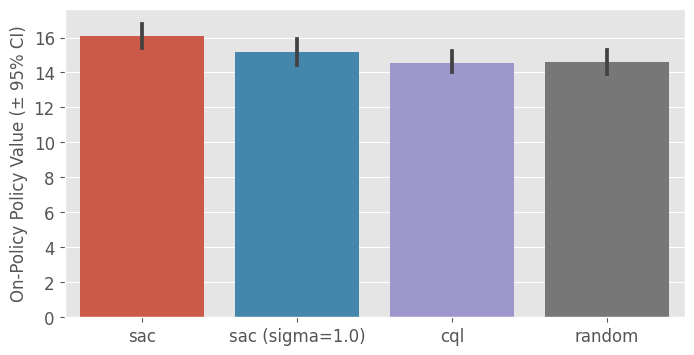

In [34]:
# compare the policy performance online
# wow, offline algorithm outperforms the online algorithm.
# even though it requires no interaction with the environment!
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, behavior_policy, cql, random],
    policy_names=["sac", "sac (sigma=1.0)", "cql", "random"],
    n_trajectories=100,
    random_state=random_state,
)

## 3. Off-Policy Evaluation and Evaluation of Offline RL methods
In the previous section, we verified the performance of a learned policy via online interaction (aka A/B tests).  
However, it could be risky in practice, because the policy may perform poorly in an online environment.  
To tackle this issue, we aim at evaluating the performance of a policy offline, to gain some prior knowledge on how the agent works in the environment.

#### Estimation Target

The goal to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [35]:
# import ope modules from SCOPE-RL
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
from scope_rl.ope import ContinuousDirectMethod as DM
from scope_rl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from scope_rl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from scope_rl.ope import ContinuousDoublyRobust as DR
from scope_rl.ope import ContinuousSelfNormalizedTIS as SNTIS
from scope_rl.ope import ContinuousSelfNormalizedPDIS as SNPDIS
from scope_rl.ope import ContinuousSelfNormalizedDR as SNDR
from scope_rl.policy import ContinuousEvalHead

In [36]:
# define evaluation policies (should be deterministic policy)
cql_ = ContinuousEvalHead(
    base_policy=cql,
    name="cql",
)
sac_ = ContinuousEvalHead(
    base_policy=sac, 
    name="sac", 
)
evaluation_policies = [cql_, sac_]

In [37]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        },
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
)

In [ ]:
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [58]:
with open("logs/ope_input_dict_continuous.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [59]:
with open("logs/ope_input_dict_continuous.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [60]:
input_dict

{'cql': {'evaluation_policy_action_dist': None,
  'evaluation_policy_action': array([[9.583781 ],
         [2.0825675],
         [2.7152529],
         ...,
         [6.2944374],
         [5.4638476],
         [4.118234 ]], dtype=float32),
  'state_action_value_prediction': array([[3.98989558, 4.03704357],
         [3.967417  , 4.07638502],
         [2.4465394 , 2.40534329],
         ...,
         [4.49536133, 4.24649858],
         [3.73993659, 3.51138902],
         [2.63690472, 2.60676837]]),
  'initial_state_value_prediction': array([4.03704357, 3.60155201, 3.56877494, ..., 3.63447595, 4.33172178,
         4.51428556]),
  'state_action_marginal_importance_weight': None,
  'state_marginal_importance_weight': None,
  'on_policy_policy_value': array([ 8.,  9., 10., 16., 14., 12., 16., 19., 13., 14., 26., 13., 12.,
          8., 15., 15., 14., 19., 11., 13., 11., 16., 16.,  8., 14., 12.,
         18., 16., 13., 13., 16., 11., 10., 14., 12., 18., 17., 13., 15.,
          9., 26., 12., 10.,

In [61]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [62]:
# performance estimation by ope
# takes time to compute (about 15min)
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [63]:
# estimated policy performance
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy     14.570000               1.000000
 dm             4.024898               0.276246
 tis           10.352664               0.710547
 pdis           8.870421               0.608814
 dr            10.169402               0.697969
 sntis         13.799337               0.947106
 snpdis        14.111458               0.968528
 sndr          14.124391               0.969416,
 'sac':            policy_value  relative_policy_value
 on_policy     16.080000               1.000000
 dm             5.249949               0.326489
 tis           18.208203               1.132351
 pdis           7.983868               0.496509
 dr             7.547519               0.469373
 sntis         14.987088               0.932033
 snpdis        14.168732               0.881140
 sndr          13.886267               0.863574}

In [64]:
# estimated confidence intervals of the policy performance
policy_value_interval_df_dict

{'cql':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  14.495000         13.764750         15.177250
 dm          4.024655          4.016541          4.031111
 tis        10.402218          5.099052         16.479156
 pdis        9.001785          7.514974         10.784976
 dr         10.299045          8.387405         12.242219
 sntis      13.865388          6.796659         21.965498
 snpdis     14.276742         12.399686         16.518259
 sndr       14.305732         11.875867         16.912096,
 'sac':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  16.073800         15.393750         16.803000
 dm          5.249606          5.240831          5.256878
 tis        18.266792         15.582707         21.132724
 pdis        7.970509          7.777577          8.183421
 dr          7.512325          6.868786          8.040462
 sntis      15.035311         12.826053         17.394246
 snpdis     14.144890         13.811994         14.483919

## 4. Evaluation of OPE methods
Now, we evaluate how well the ope estimators estimated the policy value.

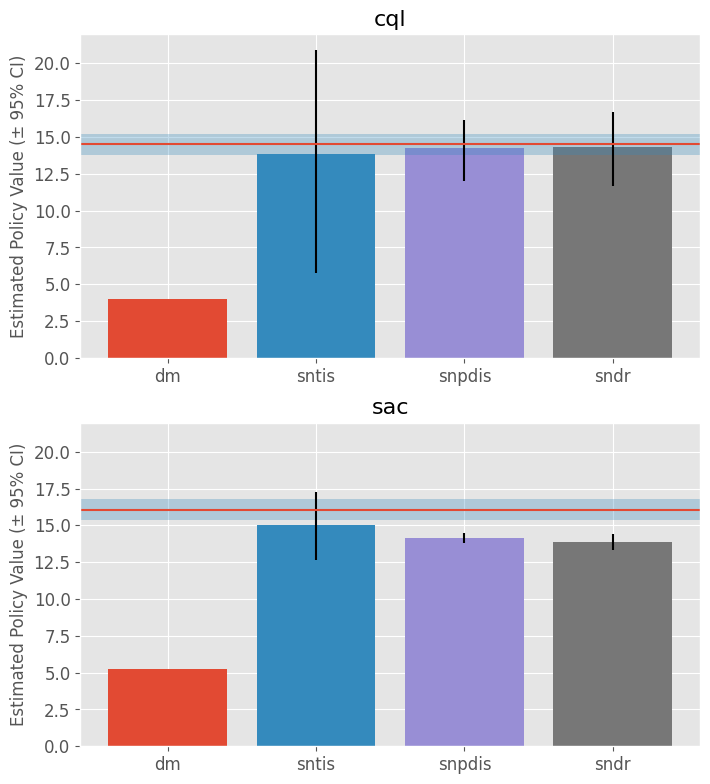

In [65]:
# we can visualize and compare the ope result
# it seems many offline metrics underestimate the policy value
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    random_state=random_state, 
    sharey=True,
)

In [66]:
# squared-error (se) measures the estimation accuracy of OPE
eval_metric_ope_df = ope.evaluate_performance_of_ope_estimators(
    input_dict, 
    metric="se",
    return_by_dataframe=True,
)
eval_metric_ope_df

,cql,sac
dm,111.199176,117.290004
tis,17.785922,4.529250
pdis,32.485196,65.547356
dr,19.365265,72.803229
sntis,0.593922,1.194458
snpdis,0.210261,3.652945
sndr,0.198568,4.812463


For more advanced topics in OPE (e.g., cumulative distribution function estimation) and OPS, please refer to [examples/quickstart/rtb/rtb_synthetic_continuous_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_continuous_advanced.ipynb). 

For more advanced OPE estimators (e.g., state(-action) marginal estimators and double reinforcement learning), please refer to [examples/quickstart/rtb/rtb_synthetic_continuous_zoo.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_continuous_zoo.ipynb). 

For examples regarding the discrete action space, please refer to [examples/quickstart/rtb/rtb_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_discrete_basic.ipynb).

## Reference

- Haanvid Lee, Jongmin Lee, Yunseon Choi, Wonseok Jeon, Byung-Jun Lee, Yung-Kyun Noh, and Kee-Eung Kim. \
"Local Metric Learning for Off-Policy Evaluation in Contextual Bandits with Continuous Actions.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Angela Zhou. \
"Policy Evaluation and Optimization with Continuous Treatments.", 2019.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.